# Assignment 2 - Predictive Process Monitoring

*Due: Friday, 15 December, 2023 at 14:00 CET*

In this assignment, you will learn to use several regression models to predict the process remaining time. In addition, you will also show that you can evaluate their performance and discuss the results in a report. The learning objectives of this assignment are: 

- use the data aggregation, feature encoding, and data transformation techniques to preprocess event data
- use the regression models to predict the remaining time of ongoing cases. 
- perform cross validation and fine-tune the model parameters of each algorithm
- calculate model performance (e.g., MAE, MSE, RMSE, R^2, etc.)
- design experiments to compare the performance of algorithms
- reflect on the difference between different models


This assignment includes two algorithms: Regression Tree (or Random Forest Regression) and kNN regressor. Following a similar structure as the first assignment, your first task is to perform data exploration and data cleaning. 
In Task 2, you will perform two trace encoding techniques (covered during Lecture 07). 
In Task 3-4, you will use the two algorithms to learn regression models to forecast the remaining time of each case after each event. 
In Task 5, you will compare the algorithms and evaluate their results. 

Please note that Task 3 and 4 have the following structure:
1. First, find the library (e.g., sklearn examples) and try out the algorithm by simply training the model on the training data (do not consider any parameters or cross validation just yet); 
2. Train the model with the training data by using cross validation and find the best parameter setting for the parameters of interest;
3. Report the average MAE, MSE, RMSE, and R^2 of all validation sets;
4. Finally, test the optimal model that has the best fitting parameters on your held-out test data, and report its MAE, MSE, RMSE, and R^2. 

Note that, in Task 5, you will need all the calculated MAE, MSE, RMSE, and R^2 on both encoded data from previous tasks. Make sure you save these to a list or dictionary so you can easily evaluate and compare the results. 



## Task 1: Exploring the data set



### Data set: Sepsis

Import the file *sepsis.csv* to load the Sepsis data set. This real-life event log contains events of sepsis cases from a hospital. Sepsis is a life threatening condition typically caused by an infection. One case represents a patient's pathway through the treatment process. The events were recorded by the ERP (Enterprise Resource Planning) system of the hospital. The original data set contains about 1000 cases with in total 15,000 events that were recorded for 16 different activities. Moreover, 39 data attributes are recorded, e.g., the group responsible for the activity, the results of tests and information from checklists. 

Additional information about the data can be found :
- https://data.4tu.nl/articles/dataset/Sepsis_Cases_-_Event_Log/12707639
- http://ceur-ws.org/Vol-1859/bpmds-08-paper.pdf




In [8]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_classif

# Import data
# TODO: Change the file path to your file path
data_sepsis = pd.read_csv("./sepsis.csv", sep=";")

# create an overview of the data
# print(data_Sepsis.describe())
print(data_sepsis.columns)
print(data_sepsis.head())
print(data_sepsis['Activity'].unique())

Index(['DiagnosticArtAstrup', 'DiagnosticBlood', 'DiagnosticECG',
       'DiagnosticIC', 'DiagnosticLacticAcid', 'DiagnosticLiquor',
       'DiagnosticOther', 'DiagnosticSputum', 'DiagnosticUrinaryCulture',
       'DiagnosticUrinarySediment', 'DiagnosticXthorax', 'DisfuncOrg',
       'Hypotensie', 'Hypoxie', 'InfectionSuspected', 'Infusion', 'Oligurie',
       'SIRSCritHeartRate', 'SIRSCritLeucos', 'SIRSCritTachypnea',
       'SIRSCritTemperature', 'SIRSCriteria2OrMore', 'Age', 'Case ID',
       'Activity', 'Diagnose', 'org:group', 'CRP', 'LacticAcid', 'Leucocytes',
       'Complete Timestamp', 'duration', 'month', 'weekday', 'hour', 'remtime',
       'elapsed'],
      dtype='object')
  DiagnosticArtAstrup DiagnosticBlood DiagnosticECG DiagnosticIC  \
0                True            True          True         True   
1                True            True          True         True   
2                True            True          True         True   
3                True            T

In [10]:
data_sepsis

,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,DiagnosticLacticAcid,DiagnosticLiquor,DiagnosticOther,DiagnosticSputum,DiagnosticUrinaryCulture,DiagnosticUrinarySediment,DiagnosticXthorax,DisfuncOrg,Hypotensie,Hypoxie,InfectionSuspected,Infusion,Oligurie,SIRSCritHeartRate,SIRSCritLeucos,SIRSCritTachypnea,SIRSCritTemperature,SIRSCriteria2OrMore,Age,Case ID,Activity,Diagnose,org:group,CRP,LacticAcid,Leucocytes,Complete Timestamp,duration,month,weekday,hour,remtime,elapsed
0,True,True,True,True,True,False,False,False,True,True,True,True,True,False,True,True,False,True,False,True,True,True,85.0,A,ER Sepsis Triage,A,A,21.0,2.2,9.6,2014-10-22 19:34:00,0.383333,10,2,19,0.0,1099.0
1,True,True,True,True,True,False,False,False,True,True,True,True,True,False,True,True,False,True,False,True,True,True,85.0,A,ER Triage,A,C,21.0,2.2,9.6,2014-10-22 19:33:37,6.616667,10,2,19,23.0,1076.0
2,True,True,True,True,True,False,False,False,True,True,True,True,True,False,True,True,False,True,False,True,True,True,85.0,A,Leucocytes,A,B,21.0,2.2,9.6,2014-10-22 19:27:00,0.000000,10,2,19,420.0,679.0
3,True,True,True,True,True,False,False,False,True,True,True,True,True,False,True,True,False,True,False,True,True,True,85.0,A,CRP,A,B,21.0,2.2,0.0,2014-10-22 19:27:00,0.000000,10,2,19,420.0,679.0
4,True,True,True,True,True,False,False,False,True,True,True,True,True,False,True,True,False,True,False,True,True,True,85.0,A,LacticAcid,A,B,0.0,2.2,0.0,2014-10-22 19:27:00,11.316667,10,2,19,420.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171,False,True,True,True,True,False,False,False,True,True,True,False,False,False,True,True,False,True,False,True,True,True,70.0,ZZ,Leucocytes,K,B,0.0,2.6,12.5,2014-11-13 02:07:00,0.000000,11,3,2,0.0,1950.0
5172,False,True,True,True,True,False,False,False,True,True,True,False,False,False,True,True,False,True,False,True,True,True,70.0,ZZ,LacticAcid,K,B,0.0,2.6,0.0,2014-11-13 02:07:00,17.183333,11,3,2,0.0,1950.0
5173,False,True,True,True,True,False,False,False,True,True,True,False,False,False,True,True,False,True,False,True,True,True,70.0,ZZ,ER Sepsis Triage,K,A,0.0,0.0,0.0,2014-11-13 01:49:49,0.200000,11,3,1,1031.0,919.0
5174,False,True,True,True,True,False,False,False,True,True,True,False,False,False,True,True,False,True,False,True,True,True,70.0,ZZ,ER Triage,K,C,0.0,0.0,0.0,2014-11-13 01:49:37,15.116667,11,3,1,1043.0,907.0


In [22]:
data_sepsis.describe()

,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,DiagnosticLacticAcid,DiagnosticLiquor,DiagnosticOther,DiagnosticSputum,DiagnosticUrinaryCulture,DiagnosticUrinarySediment,...,Age,CRP,LacticAcid,Leucocytes,duration,month,weekday,hour,remtime,elapsed
count,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,...,5176.000000,5176.000000,5176.000000,5176.000000,5176.000000,5176.000000,5176.000000,5176.000000,5176.000000,5176.000000
mean,0.284120,0.787155,0.726454,0.811044,0.766791,0.005874,0.007832,0.028784,0.450362,0.493832,...,70.191267,33.845634,0.547276,4.700155,8.265385,6.531685,2.930835,11.244397,1193.775889,1574.430835
std,0.451038,0.409359,0.445822,0.391512,0.422916,0.076426,0.088162,0.167215,0.497579,0.500011,...,17.418468,74.729799,1.187220,10.590811,35.952867,3.568158,2.018046,8.203143,3469.657735,4087.046260
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,60.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,3.000000,0.000000,155.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,75.000000,0.000000,0.000000,0.000000,0.266667,6.000000,3.000000,9.000000,236.500000,759.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,85.000000,20.000000,0.700000,8.800000,7.366667,10.000000,5.000000,19.000000,1173.500000,1553.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,90.000000,573.000000,11.000000,296.200000,782.466667,12.000000,6.000000,23.000000,47793.000000,47793.000000


In [21]:
data_sepsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5176 entries, 0 to 5175
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DiagnosticArtAstrup        5107 non-null   float64
 1   DiagnosticBlood            5107 non-null   float64
 2   DiagnosticECG              5107 non-null   float64
 3   DiagnosticIC               5107 non-null   float64
 4   DiagnosticLacticAcid       5107 non-null   float64
 5   DiagnosticLiquor           5107 non-null   float64
 6   DiagnosticOther            5107 non-null   float64
 7   DiagnosticSputum           5107 non-null   float64
 8   DiagnosticUrinaryCulture   5107 non-null   float64
 9   DiagnosticUrinarySediment  5107 non-null   float64
 10  DiagnosticXthorax          5107 non-null   float64
 11  DisfuncOrg                 5107 non-null   float64
 12  Hypotensie                 5107 non-null   float64
 13  Hypoxie                    5107 non-null   float


### 1.1 Exploratory data analysis

For the data set, create 2-3 figures and tables that help you understand the data 

**Use the column "remtime" (which indicates the remaining time of each case after each corresponding event) as the response variable for regression**

Note that some of these variables are categorical variables. How would you preprocess these variables?


#### Tips: ---------------

During the data exploration, you, as a team, are trying to get an impression of the data. You will create figures and/or tables that help you to get to know the data. While exploring the data, you may also consider answering the following questions, which may help you understand the data better. For example, 

- How many variables are in the data? What are the data type and the distribution of each variable? 
- What is the discribution of the response variable?
- Are the variables informative?
- Are any pair of the potential predictor variables highly correlated?
- (Should the variables be normalized or not?)
- (Any relevant, useful preprocessing steps that may be taken?)



Make sure to at least check the data type of each variable and to understand the distribution of each variable, especially the response variable. 

Try to find out what factors seem to determine whether an instance is an outlier or not. What do you conclude?

*For creating data visualizations, you may consider using the matplot library and visit the [matplot gallery](https://matplotlib.org/stable/gallery/index.html) for inspiration (e.g., histograms for distribution, or heatmaps for feature correlation).*

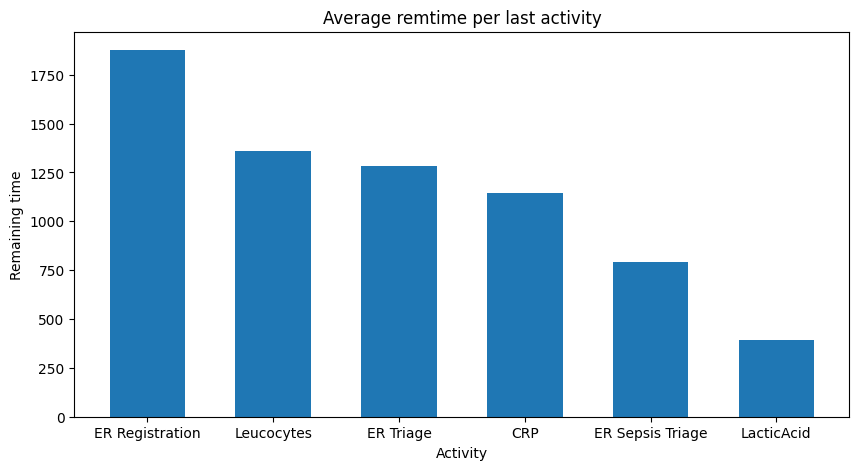

In [37]:
import matplotlib.pyplot as plt

# Get mean remtime per activity
remtime_per_activity = data_sepsis.groupby("Activity", as_index = False)["remtime"].mean()
sorted_remtime_per_activity = remtime_per_activity.sort_values("remtime", ascending = False)

plt.figure(figsize = (10,5))
plt.bar(sorted_remtime_per_activity["Activity"], sorted_remtime_per_activity["remtime"], align = "center", width = 0.6)
plt.title("Average remtime per last activity")
plt.xlabel("Activity")
plt.ylabel("Remaining time")
plt.show()


In [34]:
data_sepsis["remtime"].value_counts().sort_index()

remtime
0.0        2095
1.0           3
7.0           4
10.0          2
11.0          4
           ... 
41111.0       2
41947.0       1
44706.0       1
46353.0       2
47793.0       2
Name: count, Length: 1812, dtype: int64

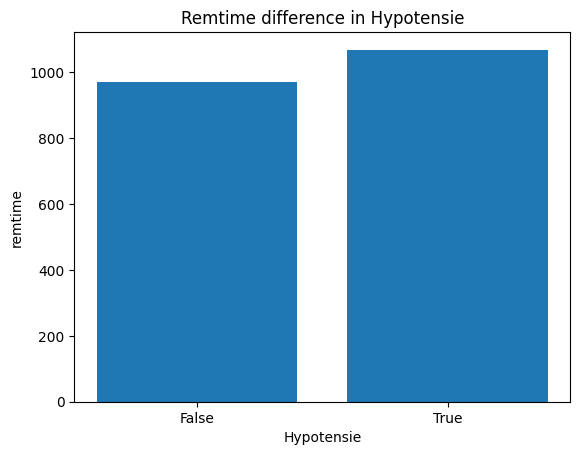

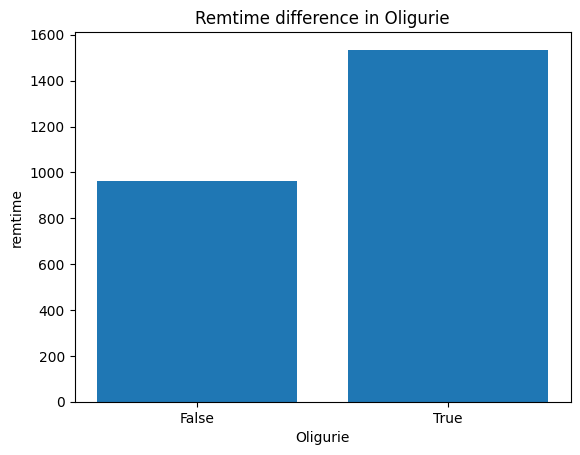

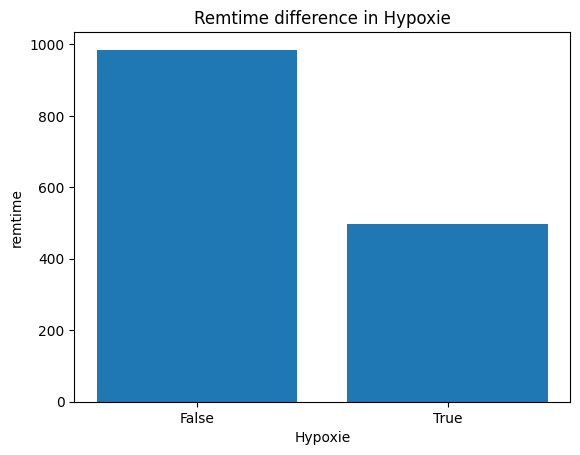

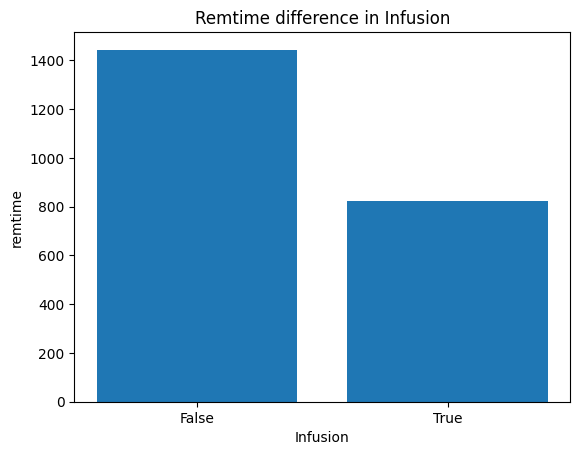

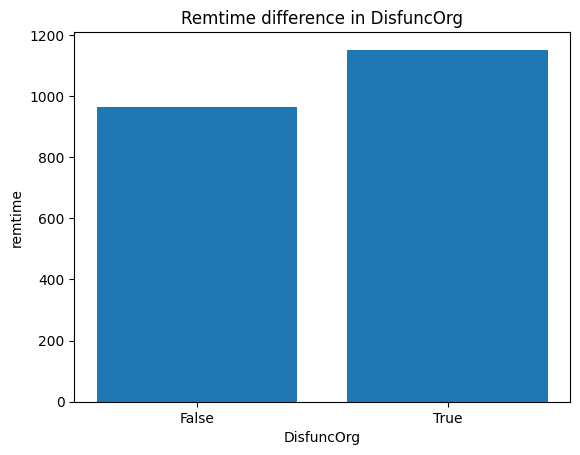

In [47]:
# hypotensie / oligurie / hypoxie / infusion / disfuncorg

def plot_fig(df, x, y, title, xlabel, ylabel):
    plt.bar(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Hypotensia
    
for col in ["Hypotensie", "Oligurie", "Hypoxie", "Infusion", "DisfuncOrg"]:
    data_without_missing = data_sepsis.drop(data_sepsis[data_sepsis[col] == "missing"].index)
    
    data_group = pd.DataFrame(data_without_missing.groupby(col, as_index = False)["remtime"].mean())
    title = f"Remtime difference in {col}"
    xlabel = col
    ylabel = "remtime"
    plot_fig(df=data_group, x=col, y="remtime", title=title, xlabel=xlabel, ylabel=ylabel)




In [39]:
print(data_sepsis["CRP"].max())
print(data_sepsis["LacticAcid"].max())
print(data_sepsis["Leucocytes"].max())

573.0
11.0
296.2


In [66]:
# Plot CRP / LacticAcid / Leucocytes against remtime, age
cases_per_day = data_sepsis.groupby(["weekday"]).size()

cases_per_day

plt.bar([""], sorted_remtime_per_activity["remtime"], align = "center", width = 0.6)
plt.title("Average remtime per last activity")
plt.xlabel("Activity")
plt.ylabel("Remaining time")
plt.show()



weekday
0    806
1    742
2    755
3    732
4    737
5    650
6    754
dtype: int64

In [90]:
# Question 1: medical guidelines There are two time rules specified by the sepsis guideline:
# 1. between ER Sepsis Triage and IV Antibiotics should be less than 1 hour,
# 2. between ER Sepsis Triage and LacticAcid should be less than 3 hours.

# PER CASE ID : CHECK HOE GROOT GEM. TIJD IS TUSSEN ER SEPSIS TRIAGE / LACTICACID

data_sepsis['Complete Timestamp'] = pd.to_datetime(data_sepsis['Complete Timestamp'])

grouped = data_sepsis.groupby("Case ID").apply(lambda x: (x.loc[x["Activity"] == "LacticAcid"]["Complete Timestamp"] - x.loc[x["Activity"] == "ER Sepsis Triage"]["Complete Timestamp"]).dt.seconds)

pd.DataFrame(grouped)

Complete Timestamp
Case ID                         
A       0                    NaN
        4                    NaN
AA      7                    NaN
        9                    NaN
AAA     12                   NaN
...                          ...
ZX      5161                 NaN
ZY      5166                 NaN
        5167                 NaN
ZZ      5172                 NaN
        5173                 NaN

[1594 rows x 1 columns]

C:\Users\danie\AppData\Local\Temp\ipykernel_8420\3231487735.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


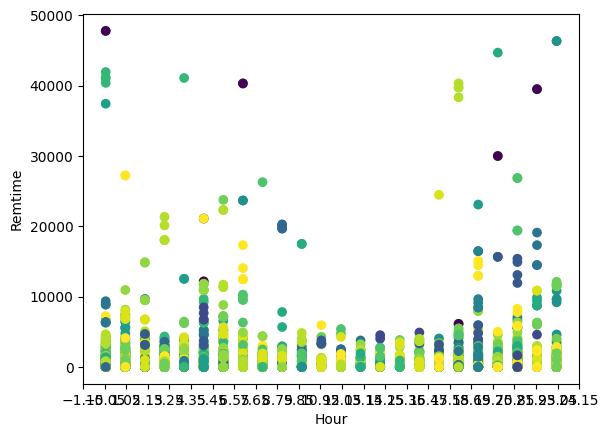

In [36]:
# import packages

from matplotlib.ticker import LinearLocator

# TODO: plot figure(s)

fig, ax = plt.subplots()
ax.scatter(data_sepsis["hour"].sort_values(), data_sepsis["remtime"].astype(int), c = data_sepsis["Age"])
ax.set_xlabel("Hour")
ax.set_ylabel("Remtime")
ax.xaxis.set_major_locator(LinearLocator(numticks = 24))
ax.xaxis.set_major_formatter()
fig.show()


In [20]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows = 4,
    cols = 3,
    subplot_titles = (
        ""
    ) 
)

cols = [
    'DiagnosticArtAstrup', 'DiagnosticBlood', 'DiagnosticECG',
    'DiagnosticIC', 'DiagnosticLacticAcid', 'DiagnosticLiquor',
    'DiagnosticOther', 'DiagnosticSputum', 'DiagnosticUrinaryCulture',
    'DiagnosticUrinarySediment', 'DiagnosticXthorax'
]

# Fig1
figure1_1 = go.Figure(go.Box(x = data_sepsis[data_sepsis["DiagnosticArtAstrup"].astype(int) == 1], y = data_sepsis["remtime"], name = "1"))
figure1_0 = go.Figure(go.Box(x = data_sepsis[data_sepsis["DiagnosticArtAstrup"].astype(int) == 0], y = data_sepsis["remtime"], name = "0"))
    
fig.show()




IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

### 1.2 Data cleaning

You have now gathered some information about the data during the data exploration task. You also know from the assignment description that you will be using regression trees and kNN regression models to predict the remaining time.

Based on the above information, decide on which cleaning steps you will need to perform and implement them accordingly.


In [4]:
# TODO: fill in the empty cells if necessary


# TODO: perform data transformation steps if necessary


def object_to_bool(df_row: pd.Series):
    df_row.replace({'True': 1, 'False': 0, 'missing': np.nan}, inplace=True)
for column in data_sepsis:
    object_to_bool(data_sepsis[column])
data_sepsis['Complete Timestamp'] = pd.to_datetime(data_sepsis['Complete Timestamp'])
df_sorted = data_sepsis.sort_values(by="Complete Timestamp")
df_sorted.reset_index(inplace=True, drop=True)
df_sorted.groupby(by="Case ID")
pd.set_option("display.max_columns", None)
df_sorted.head()
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
scaler = MinMaxScaler()
encoder = OrdinalEncoder()
df_analysis = df_sorted.copy()
df_encoded = pd.get_dummies(df_analysis[['Diagnose', 'org:group']], prefix=['Diagnose=', 'org:group='])
for col in df_encoded.columns:
    df_encoded[col].replace({True: 1, False: 0}, inplace=True)
df_analysis = pd.concat([df_analysis, df_encoded], axis=1)
df_analysis['Complete Timestamp'] = encoder.fit_transform(df_analysis['Complete Timestamp'].values.reshape(-1, 1))
scale_cols = ['CRP', 'LacticAcid', 'Leucocytes', 'duration', 'month', 'weekday', 'hour', 'remtime', 'elapsed', 'Complete Timestamp', "Age"]
df_analysis[scale_cols] = scaler.fit_transform(df_analysis[scale_cols])
df_analysis.drop(columns=['Diagnose', 'org:group'], inplace=True)


### 1.3 Process Discovery and Visualization (Optional)

This is an optional task to show you how process discovery and visualizaion can be deployed using the pm4py library. 

(*The following code requires the graphviz library to be installed. If you have issues with installing the graphviz, you may try to follow the instructions on Install GraphViz on the [pm4py](https://pm4py.fit.fraunhofer.de/install-page) install page*)

The following code:
- fill in the columns for case id, activity, and timestamps
- convert the data set into an event log
- discover a Directly-follows graph (DFG) and a process model for each event log. 
- you may use the discovered process model in your report



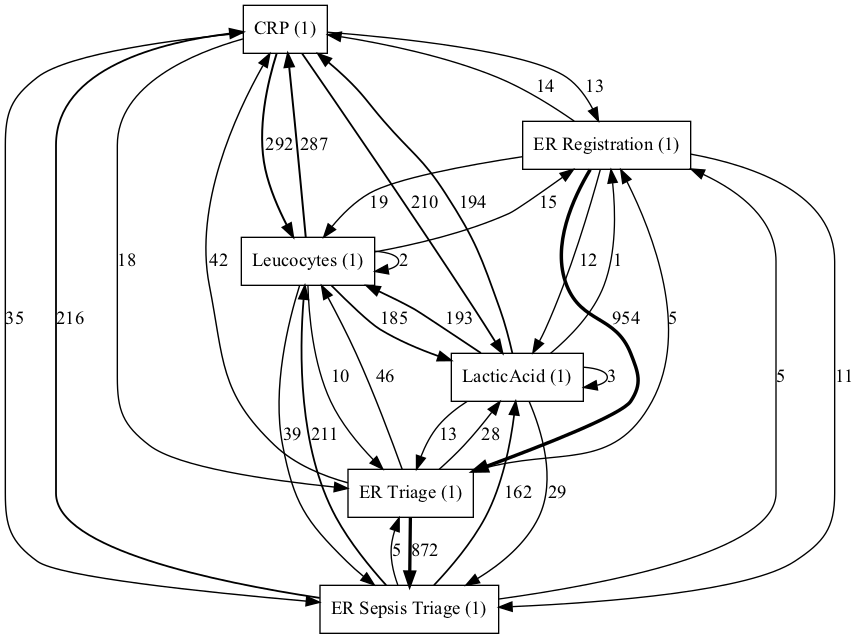

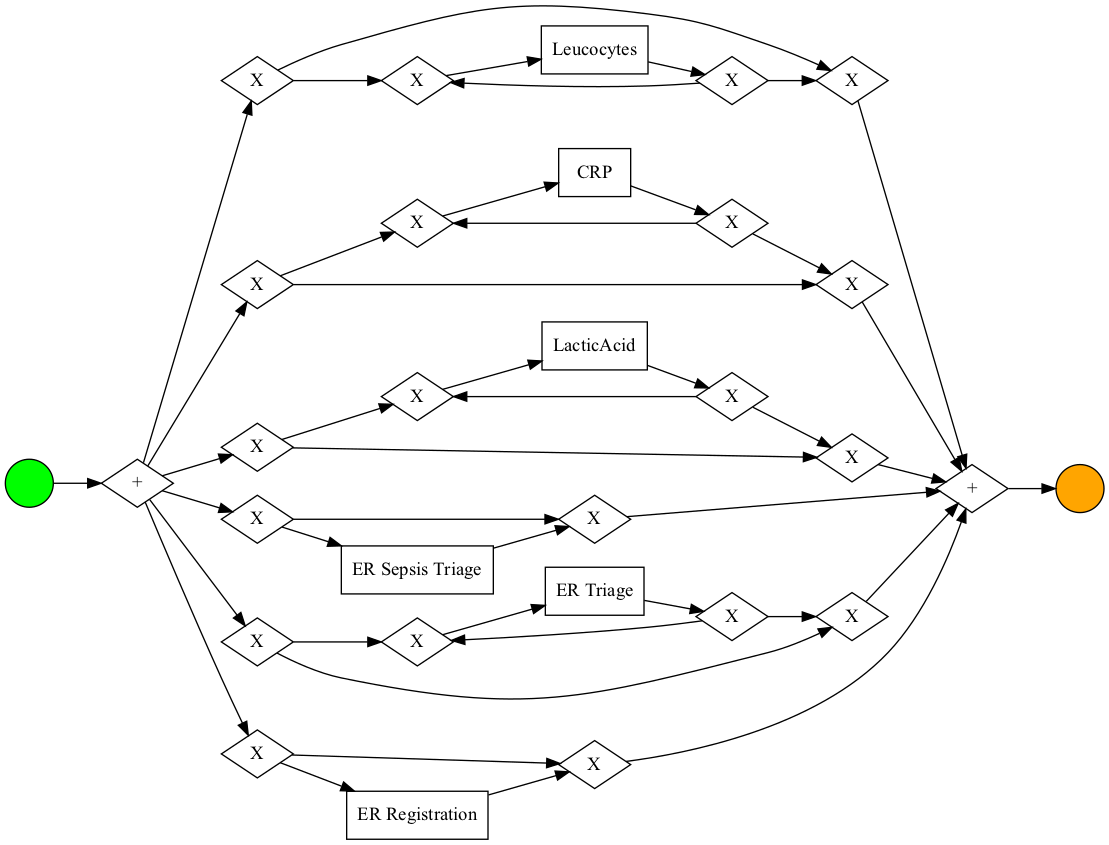

In [2]:
# Install pm4py library and graphviz library using pip install 
# !pip install -U pm4py
# !pip install graphviz
import pm4py

# Fill in the column names of case id, activity, and time stamps
column_Sepsis_CaseID = 'Case ID' 
column_Sepsis_Activity = 'Activity'
column_Sepsis_Timestamps = 'Complete Timestamp'

data_sepsis[column_Sepsis_CaseID] = data_sepsis[column_Sepsis_CaseID].astype(str)


# Convert the data to an event log
log_Sepsis = pm4py.format_dataframe(data_sepsis, case_id=column_Sepsis_CaseID, activity_key=column_Sepsis_Activity, timestamp_key=column_Sepsis_Timestamps)

# Set the log to be the one that you are interested
log = log_Sepsis

# Create a Directly-Follows Graph (DFG) and plot this graph
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

# Discover a Process Model using Inductive Miner and plot this BPMN model
process_tree = pm4py.discover_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)


## Task 2: Preprocessing and Trace Encoding


### 2.1 Trace Encoding


- Implement the last-2-state encoding for the data set 
- Implement the aggregated encoding for the data set (for example, see [1], Table 6)


<span style="color:gray">[1] Ilya Verenich, Marlon Dumas, Marcello La Rosa, Fabrizio Maria Maggi, Irene Teinemaa:
Survey and Cross-benchmark Comparison of Remaining Time Prediction Methods in Business Process Monitoring. ACM Trans. Intell. Syst. Technol. 10(4): 34:1-34:34 (2019) [Section 1, 2, 4.1, 4.3, 4.6, 5.2, 5.3, 5.4, and 6] </span>

These two encodings are discussed during lecture 7.
In case you find difficult to implement the algorithms, you may also consider use the pandas functions to help you:
- for the last-2-state encoding, check the pandas groupby.DataFrameGroupBy.shift and see the [answer on the stake overflow](https://stackoverflow.com/questions/53335567/use-pandas-shift-within-a-group)
- for the aggregated encoding check the pandas groupby.DataFrameGroupBy and cumsum function and read the [examples and answers on the stake overflow](https://stackoverflow.com/a/49578219)

In [5]:
# TODO: Implement the function that returns the last-state encoding of a log
def last_2_state_encoding(_data, columncase, columnactivity):
    _data.groupby(by = columncase)
    df_sorted = _data.copy()
    df_sorted['prev_activity'] = np.where(df_sorted[columncase] == df_sorted[columncase].shift(1), df_sorted[columnactivity].shift(1), None)
    df_sorted['prev_2_activity'] = np.where(df_sorted[columncase] == df_sorted[columncase].shift(2), df_sorted[columnactivity].shift(2), None)

    return (df_sorted)

data_Sepsis_ls = last_2_state_encoding(data_sepsis, "Case ID", "Activity")

In [6]:
data_Sepsis_ls

,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,DiagnosticLacticAcid,DiagnosticLiquor,DiagnosticOther,DiagnosticSputum,DiagnosticUrinaryCulture,DiagnosticUrinarySediment,...,Leucocytes,Complete Timestamp,duration,month,weekday,hour,remtime,elapsed,prev_activity,prev_2_activity
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,9.6,2014-10-22 19:34:00,0.383333,10,2,19,0.0,1099.0,None,None
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,9.6,2014-10-22 19:33:37,6.616667,10,2,19,23.0,1076.0,ER Sepsis Triage,None
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,9.6,2014-10-22 19:27:00,0.000000,10,2,19,420.0,679.0,ER Triage,ER Sepsis Triage
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2014-10-22 19:27:00,0.000000,10,2,19,420.0,679.0,Leucocytes,ER Triage
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2014-10-22 19:27:00,11.316667,10,2,19,420.0,679.0,CRP,Leucocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,12.5,2014-11-13 02:07:00,0.000000,11,3,2,0.0,1950.0,CRP,None
5172,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2014-11-13 02:07:00,17.183333,11,3,2,0.0,1950.0,Leucocytes,CRP
5173,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2014-11-13 01:49:49,0.200000,11,3,1,1031.0,919.0,LacticAcid,Leucocytes
5174,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2014-11-13 01:49:37,15.116667,11,3,1,1043.0,907.0,ER Sepsis Triage,LacticAcid


In [8]:
data_sepsis["Activity"].value_counts()

Activity
ER Registration     1033
ER Triage           1006
ER Sepsis Triage     993
Leucocytes           779
CRP                  764
LacticAcid           601
Name: count, dtype: int64

In [9]:
# TODO: Implement the function that returns the aggregated state encoding of a log
target_columns = ['act_CRP', 'act_ER Registration', 'act_ER Sepsis Triage', 'act_ER Triage', 'act_LacticAcid', 'act_Leucocytes']

def agg_state_encoding(_data: pd.DataFrame):
    df_aggstate = pd.get_dummies(_data, prefix='act', columns=["Activity"])
    df_aggstate[target_columns] = df_aggstate.groupby(by='Case ID')[target_columns].cumsum()

    return(df_aggstate)


# TODO: for each of the two data sets, create a last_2_state encoding and an aggregated state encoding
data_Sepsis_ag = agg_state_encoding(data_sepsis)

In [11]:
data_Sepsis_ag.head(20)

,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,DiagnosticLacticAcid,DiagnosticLiquor,DiagnosticOther,DiagnosticSputum,DiagnosticUrinaryCulture,DiagnosticUrinarySediment,...,weekday,hour,remtime,elapsed,act_CRP,act_ER Registration,act_ER Sepsis Triage,act_ER Triage,act_LacticAcid,act_Leucocytes
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,19,0.0,1099.0,0,0,1,0,0,0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,19,23.0,1076.0,0,0,1,1,0,0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,19,420.0,679.0,0,0,1,1,0,1
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,19,420.0,679.0,1,0,1,1,0,1
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,19,420.0,679.0,1,0,1,1,1,1
5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,19,1099.0,0.0,1,1,1,1,1,1
6,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,18,0.0,1516.0,1,0,0,0,0,0
7,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,18,0.0,1516.0,1,0,0,0,1,0
8,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,18,0.0,1516.0,1,0,0,0,1,1
9,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,2,18,1465.0,51.0,1,0,1,0,1,1


In [109]:

enc_data = pd.get_dummies(data_sepsis, columns = ["Activity"])
for col in enc_data.columns:
    print(col)

DiagnosticArtAstrup
DiagnosticBlood
DiagnosticECG
DiagnosticIC
DiagnosticLacticAcid
DiagnosticLiquor
DiagnosticOther
DiagnosticSputum
DiagnosticUrinaryCulture
DiagnosticUrinarySediment
DiagnosticXthorax
DisfuncOrg
Hypotensie
Hypoxie
InfectionSuspected
Infusion
Oligurie
SIRSCritHeartRate
SIRSCritLeucos
SIRSCritTachypnea
SIRSCritTemperature
SIRSCriteria2OrMore
Age
Case ID
Diagnose
org:group
CRP
LacticAcid
Leucocytes
Complete Timestamp
duration
month
weekday
hour
remtime
elapsed
Activity_CRP
Activity_ER Registration
Activity_ER Sepsis Triage
Activity_ER Triage
Activity_LacticAcid
Activity_Leucocytes


### 2.2 Create Training and Held-out test data sets


Create a training and a held-out test data set. *Later in Task 3-4, the training data will be used to perform cross-validation. The held-out test data will be used to evaluate the performance of the selected models.*

Choose the size of your test data. Furthermore, how did you split the data? Motivate your choice when you discuss the experiment setup in your report. 



Tips: *You may consider reuse some of your code from Assignment 1 Task 1.2*

In [ ]:
# Create training data and held-out test data for *data_Sepsis_ag*
X = data_Sepsis_ag.drop(columns=['remtime', 'Case ID'])
y = data_Sepsis_ag['remtime']

X_agtrain, X_agtest, y_agtrain, y_agtest = train_test_split(X, y, test_size=0.30, random_state=6, shuffle=True)

## Task 3: Predicting Case Remaining Time - Regression Trees


In this task, you will use the regression tree (or random forest regression if you prefer) to learn a regression model to predict case remaining time. Very similar to how you have trained a classification model in Assignment 1, now perform the following steps to train a regression model. 

i) use the default values for the parameters to get a [Regression Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) (or a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) running on the training data. (*Optional: visualize the tree, the feature importance, and compute the error measures to get an impression of the performance of the model*).

ii) use 5-fold cross-validation to determine a possibly better choice for the two parameters *min_samples_leaf* and *max_depth*
    
iii) create 2D or 3D plot that shows how the selected parameters affect the performance. 

iv) select the best-performing regression tree (or forest), i.e., the one that achieved the lowest cross-validated errors, and report all the error measures (MAE, MSE, RMSE, R^2) of the fitted model on the held-out test data. 

    
#### TIPS:
You may consider reuse the some of your code of Assignment 1 or use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class (see an [example](https://www.dezyre.com/recipes/find-optimal-parameters-using-gridsearchcv-for-regression), but be aware that GridSearchSV does not return MAE or the other error measures (e.g., MSE, RMSE, R^2), you will need to update the scoring function)



In [ ]:
# TODO: import packages
from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor

# TODO: using *data_Sepsis_ls* and test the default regression tree model (or the random forest regressor) 

# TODO: set the search space of the parameters *min_samples_leaf* and *max_depth*

# TODO: create 5-fold cross-validation

# TODO: learn an optimal regression tree model (random forest regressor)

# TODO: create 2D or 3D plot that shows how the selected parameter values affect the MAE (or RMSE). 

# TODO: compute the performance of the model on your held-out test data


In [ ]:
# TODO: repeat the above steps for *data_Sepsis_ag*



## Task 4. Predicting Case Remaining Time - kNN Regression


In this task, you will use the kNN Regression to learn a regression model to predict case remaining time. The same as task 3, now perform the following steps to train a regression model. 

i) use the default values for the parameters to get a [kNN Regression](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) running on the training data. (*Optional: compute the error measures to get an impression of the performance of the model).

ii) use 5-fold cross-validation to determine a possibly better choice for the two parameters *n_neighbors* and *weights* 
    
iii) create 2D or 3D plot that shows how the selected parameters affect the performance. 

iv) select the best-performing kNN, i.e., the one that achieved the lowest cross-validated errors, and report all the error measures (MAE, MSE, RMSE, R^2) of the fitted model on the held-out test data. 

    
#### TIPS:
The same here, you may consider reuse the some of your code of Assignment 1 or use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class (see an [example](https://www.dezyre.com/recipes/find-optimal-parameters-using-gridsearchcv-for-regression), but be aware that GridSearchSV does not return MAE or the other error measures (e.g., MSE, RMSE, R^2), you will need to update the scoring function)







In [23]:
knr_results = pd.DataFrame(columns = ["Encoding", "Model", "n_neighbors", "weights", "MAE", "MSE", "RMSE", "R2"])

In [24]:
# Preprocessing for KNN 
# One-hot encoding the last-2-state encoded data

ohe_cols = ["prev_activity", "prev_2_activity", "Activity", "org:group", "Diagnose"]
encoded_ls_sepsis = pd.get_dummies(data_Sepsis_ls, columns = ohe_cols)
for column in encoded_ls_sepsis:
    encoded_ls_sepsis[column].replace({True: 1, "True": 1, False: 0, "False": 0, 'missing': np.nan}, inplace=True)

# KNN can not handle NaN, so we drop NaN values
encoded_ls_sepsis = encoded_ls_sepsis.dropna()


In [25]:
# Normalize data

# Create training data and held-out test data for *data_Sepsis_ls*
X = encoded_ls_sepsis.drop(columns=['remtime', 'Case ID', "Complete Timestamp"])
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
y = encoded_ls_sepsis['remtime']

X_lstrain, X_lstest, y_lstrain, y_lstest = train_test_split(X, y, test_size=0.30, random_state=6, shuffle=True)

In [26]:
X.value_counts()

DiagnosticArtAstrup  DiagnosticBlood  DiagnosticECG  DiagnosticIC  DiagnosticLacticAcid  DiagnosticLiquor  DiagnosticOther  DiagnosticSputum  DiagnosticUrinaryCulture  DiagnosticUrinarySediment  DiagnosticXthorax  DisfuncOrg  Hypotensie  Hypoxie  InfectionSuspected  Infusion  Oligurie  SIRSCritHeartRate  SIRSCritLeucos  SIRSCritTachypnea  SIRSCritTemperature  SIRSCriteria2OrMore  Age       CRP       LacticAcid  Leucocytes  duration  month     weekday   hour      elapsed   prev_activity_CRP  prev_activity_ER Registration  prev_activity_ER Sepsis Triage  prev_activity_ER Triage  prev_activity_LacticAcid  prev_activity_Leucocytes  prev_2_activity_CRP  prev_2_activity_ER Registration  prev_2_activity_ER Sepsis Triage  prev_2_activity_ER Triage  prev_2_activity_LacticAcid  prev_2_activity_Leucocytes  Activity_CRP  Activity_ER Registration  Activity_ER Sepsis Triage  Activity_ER Triage  Activity_LacticAcid  Activity_Leucocytes  org:group_A  org:group_B  org:group_C  org:group_L  Diagnose_A  

In [29]:

# TODO: using *data_Sepsis_ls* and test the default kNN Regressor model 
knr = KNeighborsRegressor()
knr.fit(X = X_lstrain, y = y_lstrain)
knr_pred = knr.predict(X = X_lstest)

default_mae = mean_absolute_error(y_true = y_lstest, y_pred = knr_pred)
default_mse = mean_squared_error(y_true = y_lstest, y_pred = knr_pred)
default_rmse = mean_squared_error(y_true = y_lstest, y_pred = knr_pred, squared = False)
default_r2 = r2_score(y_true = y_lstest, y_pred = knr_pred)

default_results = {
    "Encoding": "Last-2-state",
    "Model": "KNN regressor",
    "n_neighbors": "Default",
    "weights": "Default",
    "MAE": default_mae,
    "MSE": default_mse,
    "RMSE": default_rmse,
    "R2": default_r2
}

knr_results.loc[len(knr_results)] = default_results

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


In [30]:
knr_results

,Encoding,Model,n_neighbors,weights,MAE,MSE,RMSE,R2
0,Last-2-state,KNN regressor,Default,Default,867.905023,7.507815e+06,2740.039291,0.024845


In [31]:
# TODO: set the search space of the parameters *n_neighbors* and *weights* 
knr_params = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"]
}

# TODO: create 5-fold cross-validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 5)

# TODO: learn an optimal kNN regressor

# Make scorers
mae_scorer = make_scorer(mean_absolute_error)
mse_scorer = make_scorer(mean_squared_error)
rmse_scorer = make_scorer(mean_squared_error, squared = False)
r2_scorer = make_scorer(r2_score)

knr_scoring = {"MAE": mae_scorer, "MSE": mse_scorer, "RMSE": rmse_scorer, "R2": r2_scorer}

optimized_knr = GridSearchCV(KNeighborsRegressor(), param_grid = knr_params, scoring = knr_scoring, cv = kf, refit = "MAE")
optimized_knr.fit(X = X_lstrain, y = y_lstrain)
bestscore = optimized_knr.best_score_
cvresults = optimized_knr.cv_results_


In [32]:
for i in range(8):
    knr_results.loc[len(knr_results)] = {
        "Encoding": "Last-2-state",
        "Model": "KNN Regressor",
        "n_neighbors": cvresults["param_n_neighbors"][i],
        "weights": cvresults["param_weights"][i],
        "MAE": cvresults["mean_test_MAE"][i],
        "MSE": cvresults["mean_test_MSE"][i],
        "RMSE": cvresults["mean_test_RMSE"][i],
        "R2": cvresults["mean_test_R2"][i]
    }

In [33]:
knr_results

,Encoding,Model,n_neighbors,weights,MAE,MSE,RMSE,R2
0,Last-2-state,KNN regressor,Default,Default,867.905023,7.507815e+06,2740.039291,0.024845
1,Last-2-state,KNN Regressor,3,uniform,856.214978,5.613160e+06,2336.343535,-0.099044
2,Last-2-state,KNN Regressor,3,distance,857.243295,5.684197e+06,2358.122285,-0.128025
3,Last-2-state,KNN Regressor,5,uniform,828.125144,5.123030e+06,2230.276094,0.002349
4,Last-2-state,KNN Regressor,5,distance,826.968662,5.162221e+06,2241.632456,-0.011168
5,Last-2-state,KNN Regressor,7,uniform,826.620202,5.006414e+06,2202.861785,0.028958
6,Last-2-state,KNN Regressor,7,distance,824.692922,5.032257e+06,2210.906138,0.019530
7,Last-2-state,KNN Regressor,9,uniform,826.900029,4.955519e+06,2189.880774,0.041914
8,Last-2-state,KNN Regressor,9,distance,824.543538,4.970782e+06,2195.386560,0.035202


In [34]:
# TODO: create 2D or 3D plot that shows how the selected parameter values affect the MAE (or RMSE).

for score in knr_scoring:
    fig = px.scatter(
        knr_results,
        x = "n_neighbors",
        y = score,
        color = "weights"
    )
    fig.show()


In [35]:
# TODO: compute the performance of the model on your held-out test data
optimal_params = optimized_knr.best_params_
optimal_knr = KNeighborsRegressor(**optimal_params)
optimal_knr.fit(X = X_lstrain, y = y_lstrain)
pred = optimal_knr.predict(X = X_lstest)

optimal_mae = mean_absolute_error(y_true = y_lstest, y_pred = pred)
optimal_mse = mean_squared_error(y_true = y_lstest, y_pred = pred)
optimal_rmse = mean_squared_error(y_true = y_lstest, y_pred = pred, squared = False)
optimal_r2 = mean_squared_error(y_true = y_lstest, y_pred = pred)

optimal_results = pd.DataFrame(columns = ["Encoding", "Model", "n_neighbors", "weights", "MAE", "MSE", "RMSE", "R2"])
optimal_results.loc[len(optimal_results)] = {
    "Encoding": "Last-2-state",
    "Model": "KNN Regressor",
    "n_neighbors": optimal_params["n_neighbors"],
    "weights": optimal_params["weights"],
    "MAE": optimal_mae,
    "MSE": optimal_mse,
    "RMSE": optimal_rmse,
    "R2": optimal_r2
}

In [37]:
optimal_results

,Encoding,Model,n_neighbors,weights,MAE,MSE,RMSE,R2
0,Last-2-state,KNN Regressor,3,distance,867.988034,7.441688e+06,2727.945827,7.441688e+06


In [38]:
# TODO: repeat the above steps for *data_Sepsis_ag*

# Preprocessing for KNN 

ohe_cols = ["org:group", "Diagnose"] 
encoded_ag_sepsis = pd.get_dummies(data_Sepsis_ag, columns = ohe_cols)
for column in encoded_ag_sepsis:
    encoded_ag_sepsis[column].replace({True: 1, "True": 1, False: 0, "False": 0, 'missing': np.nan}, inplace=True)

# KNN can not handle NaN, so we drop groups with NaN values
encoded_ag_sepsis = encoded_ag_sepsis.dropna()

In [39]:
encoded_ag_sepsis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5107 entries, 0 to 5175
Data columns (total 100 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DiagnosticArtAstrup        5107 non-null   float64
 1   DiagnosticBlood            5107 non-null   float64
 2   DiagnosticECG              5107 non-null   float64
 3   DiagnosticIC               5107 non-null   float64
 4   DiagnosticLacticAcid       5107 non-null   float64
 5   DiagnosticLiquor           5107 non-null   float64
 6   DiagnosticOther            5107 non-null   float64
 7   DiagnosticSputum           5107 non-null   float64
 8   DiagnosticUrinaryCulture   5107 non-null   float64
 9   DiagnosticUrinarySediment  5107 non-null   float64
 10  DiagnosticXthorax          5107 non-null   float64
 11  DisfuncOrg                 5107 non-null   float64
 12  Hypotensie                 5107 non-null   float64
 13  Hypoxie                    5107 non-null   float64
 

In [40]:
# Normalize data
# Create training data and held-out test data for *data_Sepsis_ls*
X = encoded_ag_sepsis.drop(columns=['remtime', 'Case ID', "Complete Timestamp"])
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
y = encoded_ag_sepsis['remtime']

X_agtrain, X_agtest, y_agtrain, y_agtest = train_test_split(X, y, test_size=0.30, random_state=6, shuffle=True)

In [41]:

# TODO: using *data_Sepsis_ag* and test the default kNN Regressor model 
knr_ag = KNeighborsRegressor()
knr_ag.fit(X = X_agtrain, y = y_agtrain)
knr_agpred = knr_ag.predict(X = X_agtest)

default_ag_mae = mean_absolute_error(y_true = y_agtest, y_pred = knr_agpred)
default_ag_mse = mean_squared_error(y_true = y_agtest, y_pred = knr_agpred)
default_ag_rmse = mean_squared_error(y_true = y_agtest, y_pred = knr_agpred, squared = False)
default_ag_r2 = r2_score(y_true = y_agtest, y_pred = knr_agpred)

default_results = {
    "Encoding": "Aggregation",
    "Model": "KNN regressor",
    "n_neighbors": "Default",
    "weights": "Default",
    "MAE": default_ag_mae,
    "MSE": default_ag_mse,
    "RMSE": default_ag_rmse,
    "R2": default_ag_r2
}

knr_results.loc[len(knr_results)] = default_results

In [42]:
# TODO: set the search space of the parameters *n_neighbors* and *weights* 
knr_ag_params = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"]
}

# TODO: create 5-fold cross-validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 5)

# TODO: learn an optimal kNN regressor

optimized_ag_knr = GridSearchCV(KNeighborsRegressor(), param_grid = knr_ag_params, scoring = knr_scoring, cv = kf, refit = "MAE")
optimized_ag_knr.fit(X = X_agtrain, y = y_agtrain)
ag_bestscore = optimized_ag_knr.best_score_
ag_cvresults = optimized_ag_knr.cv_results_


In [43]:
for i in range(8):
    knr_results.loc[len(knr_results)] = {
        "Encoding": "Aggregation",
        "Model": "KNN Regressor",
        "n_neighbors": ag_cvresults["param_n_neighbors"][i],
        "weights": ag_cvresults["param_weights"][i],
        "MAE": ag_cvresults["mean_test_MAE"][i],
        "MSE": ag_cvresults["mean_test_MSE"][i],
        "RMSE": ag_cvresults["mean_test_RMSE"][i],
        "R2": ag_cvresults["mean_test_R2"][i]
    }

In [51]:
knr_results

,Encoding,Model,n_neighbors,weights,MAE,MSE,RMSE,R2
0,Last-2-state,KNN regressor,Default,Default,867.905023,7.507815e+06,2740.039291,0.024845
1,Last-2-state,KNN Regressor,3,uniform,856.214978,5.613160e+06,2336.343535,-0.099044
2,Last-2-state,KNN Regressor,3,distance,857.243295,5.684197e+06,2358.122285,-0.128025
3,Last-2-state,KNN Regressor,5,uniform,828.125144,5.123030e+06,2230.276094,0.002349
4,Last-2-state,KNN Regressor,5,distance,826.968662,5.162221e+06,2241.632456,-0.011168
5,Last-2-state,KNN Regressor,7,uniform,826.620202,5.006414e+06,2202.861785,0.028958
6,Last-2-state,KNN Regressor,7,distance,824.692922,5.032257e+06,2210.906138,0.019530
7,Last-2-state,KNN Regressor,9,uniform,826.900029,4.955519e+06,2189.880774,0.041914
8,Last-2-state,KNN Regressor,9,distance,824.543538,4.970782e+06,2195.386560,0.035202
9,Aggregation,KNN regressor,Default,Default,804.829615,5.887139e+06,2426.342718,0.235347


In [109]:
for score in knr_scoring:
    fig = px.scatter(
        knr_results.loc[knr_results["Encoding"] == "Aggregation"],
        x = "n_neighbors",
        y = score,
        color = "weights",
        title = f"{score} score with Aggregation encoding"
    )
    fig.show()
    fig = px.scatter(
        knr_results.loc[knr_results["Encoding"] == "Last-2-state"],
        x = "n_neighbors",
        y = score,
        color = "weights",
        title = f"{score} score with Last-2-state encoding"
    )
    fig.show()

In [104]:
# TODO: create 2D or 3D plot that shows how the selected parameter values affect the MAE (or RMSE).
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows = 4,
    cols = 2,
    subplot_titles = [
        "MAE score with Aggregation encoding",
        "MAE score with Last-2-state encoding",
        "MSE score with Aggregation encoding",
        "MSE score with Last-2-state encoding",
        "RMSE score with Aggregation encoding",
        "RMSE score with Last-2-state encoding",
        "R2 score with Aggregation encoding",
        "R2 score with Last-2-state encoding"
    ]
)

for score, i in zip(knr_scoring, range(1,5)):
    fig.add_trace(
        go.Scatter(
            x = knr_results.loc[(knr_results["weights"] == "uniform") & (knr_results["Encoding"] == "Aggregation")]["n_neighbors"],
            y = knr_results.loc[(knr_results["weights"] == "uniform") & (knr_results["Encoding"] == "Aggregation")][score],
            name = "Weights: Uniform"
        ),
        row = i,
        col = 1
    )
    fig.add_trace(
        go.Scatter(
            x = knr_results.loc[(knr_results["weights"] == "distance") & (knr_results["Encoding"] == "Aggregation")]["n_neighbors"],
            y = knr_results.loc[(knr_results["weights"] == "distance") & (knr_results["Encoding"] == "Aggregation")][score],
            name = "Weights: Distance"
        ),
        row = i,
        col = 1
    )

    fig.add_trace(
        go.Scatter(
            x = knr_results.loc[(knr_results["weights"] == "uniform") & (knr_results["Encoding"] == "Last-2-state")]["n_neighbors"],
            y = knr_results.loc[(knr_results["weights"] == "uniform") & (knr_results["Encoding"] == "Last-2-state")][score],
            name = "Weights: Uniform",  
        ),
        row = i,
        col = 2
    )
    fig.add_trace(
        go.Scatter(
            x = knr_results.loc[(knr_results["weights"] == "distance") & (knr_results["Encoding"] == "Last-2-state")]["n_neighbors"],
            y = knr_results.loc[(knr_results["weights"] == "distance") & (knr_results["Encoding"] == "Last-2-state")][score],
            name = "Weights: Distance"
        ),
        row = i,
        col = 2
    )

fig.show()

In [97]:
# TODO: compute the performance of the model on your held-out test data
optimal_params = optimized_ag_knr.best_params_
optimal_knr = KNeighborsRegressor(**optimal_params)
optimal_knr.fit(X = X_agtrain, y = y_agtrain)
pred = optimal_knr.predict(X = X_agtest)

optimal_mae = mean_absolute_error(y_true = y_agtest, y_pred = pred)
optimal_mse = mean_squared_error(y_true = y_agtest, y_pred = pred)
optimal_rmse = mean_squared_error(y_true = y_agtest, y_pred = pred, squared = False)
optimal_r2 = mean_squared_error(y_true = y_agtest, y_pred = pred)

optimal_results.loc[len(optimal_results)] = {
    "Encoding": "Aggregation",
    "Model": "KNN Regressor",
    "n_neighbors": optimal_params["n_neighbors"],
    "weights": optimal_params["weights"],
    "MAE": optimal_mae,
    "MSE": optimal_mse,
    "RMSE": optimal_rmse,
    "R2": optimal_r2
}

In [99]:
knr_results

,Encoding,Model,n_neighbors,weights,MAE,MSE,RMSE,R2
0,Last-2-state,KNN regressor,Default,Default,867.905023,7.507815e+06,2740.039291,0.024845
1,Last-2-state,KNN Regressor,3,uniform,856.214978,5.613160e+06,2336.343535,-0.099044
2,Last-2-state,KNN Regressor,3,distance,857.243295,5.684197e+06,2358.122285,-0.128025
3,Last-2-state,KNN Regressor,5,uniform,828.125144,5.123030e+06,2230.276094,0.002349
4,Last-2-state,KNN Regressor,5,distance,826.968662,5.162221e+06,2241.632456,-0.011168
5,Last-2-state,KNN Regressor,7,uniform,826.620202,5.006414e+06,2202.861785,0.028958
6,Last-2-state,KNN Regressor,7,distance,824.692922,5.032257e+06,2210.906138,0.019530
7,Last-2-state,KNN Regressor,9,uniform,826.900029,4.955519e+06,2189.880774,0.041914
8,Last-2-state,KNN Regressor,9,distance,824.543538,4.970782e+06,2195.386560,0.035202
9,Aggregation,KNN regressor,Default,Default,804.829615,5.887139e+06,2426.342718,0.235347


In [98]:
optimal_results

,Encoding,Model,n_neighbors,weights,MAE,MSE,RMSE,R2
0,Last-2-state,KNN Regressor,3,distance,867.988034,7.441688e+06,2727.945827,7.441688e+06
1,Aggregation,KNN Regressor,7,uniform,823.745504,6.138401e+06,2477.579645,6.138401e+06


## Task 5.  Report your results and discuss your findings

By now, you have applied two algorithms with different parameters on the two encodings of the data set. For each algorithm and each encoding, you have created tables or figures which you can add to your report. Discuss the results and their optimal performance. 

Create an overview table or figure that shows the optimal performance of each algorithm on the data set, for example, see the table here below. 


Discuss your findings and reflect on the following questions in your report:
- According to the error measures, which one would you suggest as the optimal model? 
- Are there any discrepancies between the MAE, MSE, RMSE, and R^2 measures in terms of which model performs the best? If yes, how would you explain these discrepancies. 
- Which one of the MAE, MSE, RMSE, and R^2 would you use for selecting the model? Why?
- Which one of the encoding would you suggest for this data set? Why?
- Which features have a big influence on predicting the remaining time?







| Encoding | Model | CV MAE  | Test MAE |  CV MSE  |  Test MSE  | CV R^2 | Test R^2 |... |
|------|------|------|------|------|------|------|------|-----|
|  Last-2-state | Regression Tree        |  |  | | | | |
|  Agg-state |  Regression Tree  |  |  | || | |
|   Last-2-state |kNN       |  |  | || | |
|   ... |...       |  |  | || | |











## Bonus Tasks 

We would like to challenge you with the following bonus tasks. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Implement or use another regression algorithm (for example, [Random Forest Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), [LinearRegresion](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [SVM Regression](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py)) or design your own algorithm that achieves a better MAE measure. Explain this in your report.
2. Implement techniques (e.g., preprocessing, feature engineering, feature selection, sampling) that help improve the MAE scores of existing models. For example, try out a feature selection for kNN or implement inter-case features. Explain this in your report.

